# Dependencies

In [1]:
%%capture
!pip install super-gradients==3.1.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

# Instance of the model

In [1]:
from super_gradients.training import models

yolo_nas_l = models.get("yolo_nas_l", pretrained_weights="coco")

[2023-05-11 12:06:12] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/alluvium/sg_logs/console.log


2023-05-11 12:06:14.216169: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 12:06:14.891518: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[2023-05-11 12:06:15] INFO - utils.py - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2023-05-11 12:06:15] INFO - utils.py - NumExpr defaulting to 8 threads.
[2023-05-11 12:06:16] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-05-11 12:06:16] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-05-11 12:06:16] WARNING - export.py - Failed to import pytorch_quantization
[2023-05-11 12:06:16] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantizatio

# Model Summary

In [3]:
# You can use this cell if you're interested in the model architecture
# !pip install torchinfo
from torchinfo import summary

summary(model=yolo_nas_l, 
        input_size=(16, 3, 640, 640),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
YoloNAS_L (YoloNAS_L)                                             [16, 3, 640, 640]    [16, 8400, 4]        --                   True
├─NStageBackbone (backbone)                                       [16, 3, 640, 640]    [16, 96, 160, 160]   --                   True
│    └─YoloNASStem (stem)                                         [16, 3, 640, 640]    [16, 48, 320, 320]   --                   True
│    │    └─QARepVGGBlock (conv)                                  [16, 3, 640, 640]    [16, 48, 320, 320]   3,024                True
│    └─YoloNASStage (stage1)                                      [16, 48, 320, 320]   [16, 96, 160, 160]   --                   True
│    │    └─QARepVGGBlock (downsample)                            [16, 48, 320, 320]   [16, 96, 160, 160]   88,128               True
│    │    └─YoloNASCSPLayer (blocks)                     

# Importing Dependencies

In [4]:
import torch

In [6]:
torch.__version__

'2.0.0+cu117'

In [7]:
# Because Traditions
device = 'cuda' if torch.cuda.is_available() else "cpu"

Initiating the custom model training

In [8]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='my_first_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

In [9]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="GET YOUR OWN KEY's from Roboflow")
project = rf.workspace("This too").project("Same Here")
dataset = project.version(3).download("yolov5") # Make Sure you have Yolov5 model format

/bin/bash: /home/alluvium/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Lorenzo-3 in yolov5pytorch::  93%|█████████▎| 11483/12330 [00:01<00:00, 9961.13it/s]

In [10]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

Setting up path of refrence directories in refrence path

In [11]:
dataset_params = {
    'data_dir':'/home/alluvium/alluvium/Lorenzo-3',
    'train_images_dir':'/home/alluvium/alluvium/Lorenzo-3/train/images',
    'train_labels_dir':'/home/alluvium/alluvium/Lorenzo-3/train/labels',
    'val_images_dir':'/home/alluvium/alluvium/Lorenzo-3/valid/images',
    'val_labels_dir':'/home/alluvium/alluvium/Lorenzo-3/valid/labels',
    'test_images_dir':'/home/alluvium/alluvium/Lorenzo-3/test/images',
    'test_labels_dir':'/home/alluvium/alluvium/Lorenzo-3/test/labels',
    'classes': ['Hooman', 'Machine', 'Object-A', 'Object-B', 'Object-C', 'Object-D', 'Paper']}

Adjusting the parameters

In [12]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

In [13]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1),

In [14]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [15]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

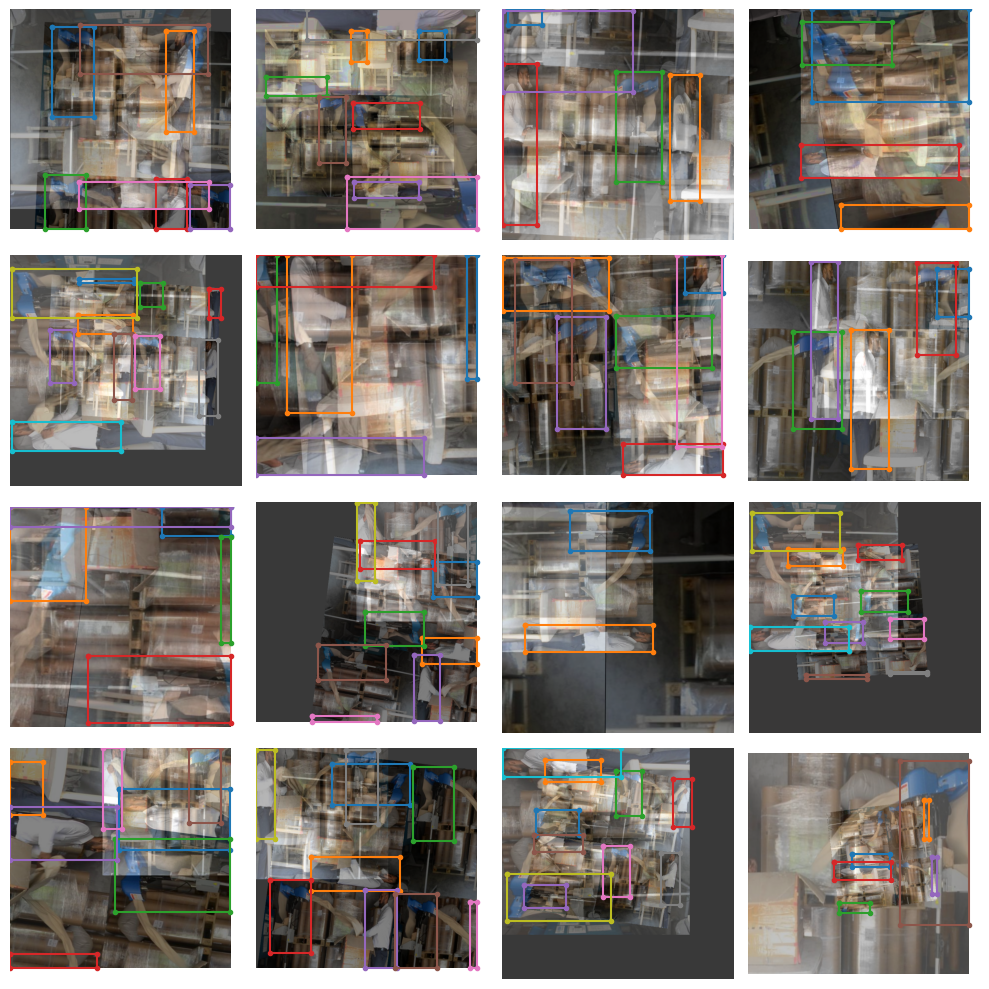

In [16]:
train_data.dataset.plot()

In [17]:
from super_gradients.training import models
model = models.get('yolo_nas_l', 
                   num_classes=len(dataset_params['classes']), 
                   pretrained_weights="coco"
                   )

[2023-05-11 12:08:25] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


Hyperparameters adjustments

In [21]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    #Training for 200 epochs because why not
    "max_epochs": 200,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

# version requirement for yolonas to work this is what i had to do. Check the compatibility chart on YOLO nas dicumentations but these goes just fine
# pip install torch==2.0.0, torchvision==0.15.1


Model will start training

In [22]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

[2023-05-11 12:19:42] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/my_first_yolonas_run/console_May11_12_19_42.txt


[2023-05-11 12:19:44] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 318        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         19         (len(train_loader))
    - Gradient updates per epoch:   19         (len(train_loader) / batch_accumulate)

[2023-05-11 12:20:21] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-05-11 12:20:21] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 1.0
[2023-05-11 14:59:58] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MO

SUMMARY OF EPOCH 200
├── Training
│   ├── Ppyoloeloss/loss = 1.3295
│   │   ├── Best until now = 1.304  (↗ 0.0255)
│   │   └── Epoch N-1      = 1.3135 (↗ 0.016)
│   ├── Ppyoloeloss/loss_cls = 0.599
│   │   ├── Best until now = 0.5893 (↗ 0.0097)
│   │   └── Epoch N-1      = 0.5917 (↗ 0.0073)
│   ├── Ppyoloeloss/loss_dfl = 0.9053
│   │   ├── Best until now = 0.8832 (↗ 0.0221)
│   │   └── Epoch N-1      = 0.8948 (↗ 0.0105)
│   └── Ppyoloeloss/loss_iou = 0.1111
│       ├── Best until now = 0.1078 (↗ 0.0033)
│       └── Epoch N-1      = 0.1097 (↗ 0.0014)
└── Validation
    ├── F1@0.50 = 0.1783
    │   ├── Best until now = 0.1923 (↘ -0.0141)
    │   └── Epoch N-1      = 0.1007 (↗ 0.0775)
    ├── Map@0.50 = 1.0
    │   ├── Best until now = 1.0    (= 0.0)
    │   └── Epoch N-1      = 1.0    (= 0.0)
    ├── Ppyoloeloss/loss = 1.501
    │   ├── Best until now = 1.1701 (↗ 0.3309)
    │   └── Epoch N-1      = 1.2983 (↗ 0.2027)
    ├── Ppyoloeloss/loss_cls = 0.7578
    │   ├── Best until now = 0.47

[2023-05-11 14:59:59] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


In [ ]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="checkpoints/my_first_yolonas_run/average_model.pth")

In [21]:
pip list

/bin/bash: /home/alluvium/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.12
anaconda-client               1.11.1
anaconda-navigator            2.4.0
anaconda-project              0.11.1
antlr4-python3-runtime        4.9.3
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4


Note: you may need to restart the kernel to use updated packages.
